# Binary Classification of Cats and Dogs Images

## Preprocessing

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Importing data
ds_train = image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode = 'binary',
    interpolation='nearest',
    image_size = [128,128],
    batch_size=64,
)

ds_valid = image_dataset_from_directory(
    'test',
    labels='inferred',
    label_mode = 'binary',
    interpolation='nearest',
    image_size = [128,128],
    batch_size=64 
)

Found 557 files belonging to 2 classes.
Found 140 files belonging to 2 classes.


### Visualization

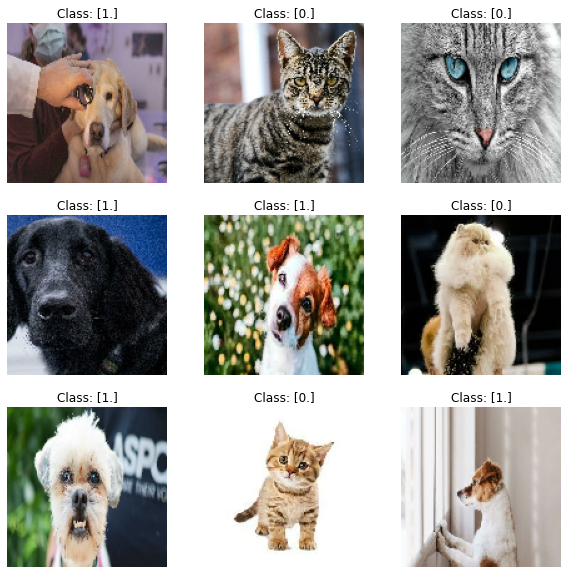

In [9]:
import matplotlib.pyplot as plt

# Selecting images and their respective labels
for images,labels in ds_train.take(1):

    # Creating figure of 10x10 (inches)
    plt.figure(figsize=(10,10))

    # Itering through images and plotting them
    ## uint8 ensures treatment as 8-bit integers
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis('off')

    plt.show()

## Data Preparation

In [10]:
# Defining function for treating images as float data
def convert_to_float(image,label):
    image = tf.image.convert_image_dtype(image,dtype=tf.float32)
    return image,label

# Optimizing CPU usage
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Converting images
## Storing data in cache memory
### Optimizing data availabilty
ds_train = (
    ds_train.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE)
)

ds_valid = (
    ds_valid.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE)
)

## Architecture of the Convolutional Neural Network

### Transfer Learning

In [11]:
from keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

### Setting up

In [12]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers.schedules import ExponentialDecay
from keras.applications import DenseNet121

early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=100,
    restore_best_weights=True
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='binary_accuracy',
    patience=100,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

learning_rate_schedule = ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 1000,
    decay_rate=0.5
)

lr_callback = LearningRateScheduler(learning_rate_schedule)
callback = [lr_callback, reduce_learning_rate, early_stopping]

for layer in base_model.layers:
    layer.trainable = False

### Building Architecture

In [13]:
# Defining the model
model = Sequential()

model.add(base_model),

model.add(Flatten()),

model.add(Dense(256, activation='relu')),

model.add(Dense(128, activation='relu')),

model.add(Dense(64, activation='relu')),

model.add(Dropout(0.5)),
model.add(Dense(1, activation='sigmoid')),

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4194560   
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

## Model Compilation

In [14]:
from keras.callbacks import ModelCheckpoint

# Compiling model
model.compile(
    optimizer = Adam(learning_rate=learning_rate_schedule),
    loss='binary_crossentropy',
    metrics = ['binary_accuracy']
)

# Fitting model
history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 500,
    verbose=1,
    callbacks = [callback]
)

Epoch 1/500
9/9 [==============================] - 18s 1s/step - loss: 24.5812 - binary_accuracy: 0.5907 - val_loss: 4.3654 - val_binary_accuracy: 0.7714 - lr: 0.0099
Epoch 2/500
9/9 [==============================] - 8s 953ms/step - loss: 1.6630 - binary_accuracy: 0.8474 - val_loss: 0.6215 - val_binary_accuracy: 0.8643 - lr: 0.0099
Epoch 3/500
9/9 [==============================] - 12s 1s/step - loss: 0.2585 - binary_accuracy: 0.8618 - val_loss: 0.5120 - val_binary_accuracy: 0.8571 - lr: 0.0098
Epoch 4/500
9/9 [==============================] - 9s 987ms/step - loss: 0.2009 - binary_accuracy: 0.9138 - val_loss: 0.8141 - val_binary_accuracy: 0.8357 - lr: 0.0098
Epoch 5/500
9/9 [==============================] - 9s 1s/step - loss: 0.2399 - binary_accuracy: 0.8923 - val_loss: 0.3622 - val_binary_accuracy: 0.8571 - lr: 0.0097
Epoch 6/500
9/9 [==============================] - 9s 1s/step - loss: 0.1892 - binary_accuracy: 0.9120 - val_loss: 0.4711 - val_binary_accuracy: 0.8571 - lr: 0.0096
E

## Visualizing Results

### Accuracy

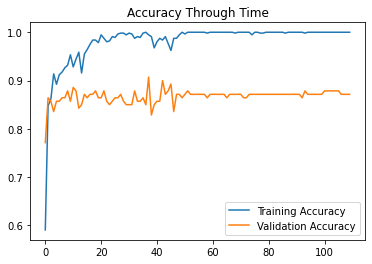

In [15]:
history.history.keys()
plt.plot(history.history['binary_accuracy'],label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'],label='Validation Accuracy')
plt.title('Accuracy Through Time')
plt.legend()

### Loss

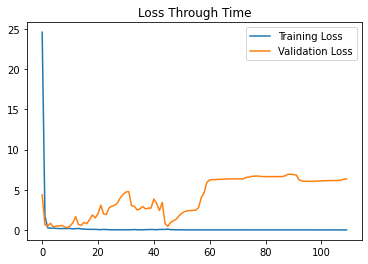

In [16]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Loss Through Time')
plt.legend()

### Evaluation

In [17]:
test_loss, test_acc = model.evaluate(ds_valid, verbose=1)

3/3 [==============================] - 2s 463ms/step - loss: 0.2800 - binary_accuracy: 0.8571


In [18]:
print(f'Acurácia: {test_acc} - Perda: {test_loss}')

Acurácia: 0.8571428656578064 - Perda: 0.28003713488578796
